# Decision tree

In [24]:
# Imports
import sqlite3
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import math
import nltk
import re

from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize

from sklearn.tree import plot_tree
from sklearn.metrics import f1_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.feature_extraction.text import TfidfVectorizer

In [25]:
# downloading stopwords
nltk.download('stopwords')
nltk.download('punkt')

# word normalizer
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/laurensheberle/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/laurensheberle/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/laurensheberle/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/laurensheberle/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /Users/laurensheberle/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [26]:
# constants
conn = sqlite3.connect('StaterData.db')
query = "SELECT * FROM 'mortgage complaints'"
dtypes = {'Date received': str,
          'Product': "category",
          'Sub-product': "category",
          'Issue': "category",
          'Sub-issue':"category",
          'Consumer complaint narrative':str,
          'Company public response':str,
          'Company':"category",
          'State':"category",
          'ZIP code':str,
          'Tags':"category",
          'Consumer consent provided?':str,
          'Submitted via':"category",
          'Date sent to company':str,
          'Company response to consumer':str,
          'Timely response?':str,
          'Consumer disputed?':str,
          'Complaint ID':int
          }

In [27]:
# remove stopwords and return the text
def remove_stopwords(text):
    stop_words = set(stopwords.words('english'))
    return " ".join([token for token in nltk.word_tokenize(text) if token.lower() not in stop_words])

def clean_text(text):
    # Remove numerical values
    text = re.sub(r'\d+', '', text)

    # Remove punctuation marks
    text = re.sub(r'[^\w\s]', '', text)

    # Remove links and URLs
    text = re.sub(r'http\S+', '', text)

    # Remove leading/trailing white space and convert to lowercase
    text = text.strip().lower()

    return text

# lemmitize the word based on its part of speech (POS) tag
def lemmatize_word(word, tag, lemmatizer):
    # Map POS tag to WordNet POS tag
    if tag.startswith('J'):
        # Adjective
        wn_tag = 'a'
    elif tag.startswith('V'):
        # Verb
        wn_tag = 'v'
    elif tag.startswith('N'):
        # Noun
        wn_tag = 'n'
    elif tag.startswith('R'):
        # Adverb
        wn_tag = 'r'
    else:
        wn_tag = None

    # Lemmatize the word
    if wn_tag:
        lemma = lemmatizer.lemmatize(word, wn_tag)
    else:
        lemma = word

    return lemma

# lemmatize the sentence that is already tokenized
def lemmatize_sentence(lemmatizer, tokens):
    # Part-of-speech (POS) tag each word
    pos_tags = nltk.pos_tag(tokens)

    # Lemmatize each word based on its POS tag
    lemmas = [lemmatize_word(word, tag, lemmatizer) for word, tag in pos_tags]

    # Join the lemmas back into a sentence
    lemmatized_sentence = ' '.join(lemmas)

    return lemmatized_sentence

def remove_non_alphabetica_char_and_x(text):
    # remove non alphabetical characters
    alphabetical_text = [re.sub('[^a-zA-Z]+', '', word) for word in text]

    # remove x from the text with regex
    alphabetical_text = [word for word in alphabetical_text if not re.match('^x+$', word)]
    return ' '.join(alphabetical_text)

def clean_complaint(complaint):
        lemmatizer = WordNetLemmatizer()
        cleaned_complaint = remove_stopwords(complaint)
        cleaned_complaint = clean_text(cleaned_complaint)

        # Tokenize the sentence into words
        tokens = nltk.word_tokenize(cleaned_complaint)
        cleaned_complaint = lemmatize_sentence(lemmatizer, tokens)
        tokenized_complaint = word_tokenize(cleaned_complaint)
        cleaned_complaint = remove_non_alphabetica_char_and_x(tokenized_complaint)
        return cleaned_complaint
    
# one for loop in batches to, remove stopwords, clean text, lemmatize, tokenize, and remove x or non alphabetic characters
def clean_complaints(df_column):
    cleaned_complaints_df = pd.DataFrame(columns=[df_column.name])
    batch_size = 10000
    batch_index = 0
    number_of_batches = math.ceil(len(df_column) / batch_size)
    while batch_index < number_of_batches:
        print(f"batch {batch_index+1} of {number_of_batches}")
        cleaned_complaints = []
        complaints = df_column[batch_index * batch_size: (batch_index + 1) * batch_size]
        for complaint in complaints:
            complaint = clean_complaint(complaint)
            cleaned_complaints.append(complaint)
        clean_complaints_df = pd.DataFrame(cleaned_complaints, columns=[df_column.name])
        cleaned_complaints_df = pd.concat([cleaned_complaints_df, clean_complaints_df], axis=0)
        batch_index += 1
        del complaints
        del complaint
        del cleaned_complaints
        del clean_complaints_df
    return cleaned_complaints_df[df_column.name]

In [28]:
# Reading the data in
data = pd.read_sql_query(query, conn, dtype=dtypes)
print("data loaded")
df = data[['Consumer complaint narrative', 'Issue']].copy()

data loaded


In [29]:
# Adding the clean text to the df
print("cleaning text")
df['Clean consumer complaint'] = clean_complaints(df['Consumer complaint narrative']).reset_index(drop=True)


cleaning text
batch 1 of 11
batch 2 of 11
batch 3 of 11
batch 4 of 11
batch 5 of 11
batch 6 of 11
batch 7 of 11
batch 8 of 11
batch 9 of 11
batch 10 of 11
batch 11 of 11


In [30]:
# Viewing the first 5 rows of the dataframe
df.head(5)

,Consumer complaint narrative,Issue,Clean consumer complaint
0,We applied to Navy Federal Credit Union for a ...,Applying for a mortgage or refinancing an exis...,apply navy federal credit union preapproval mo...
1,Spoke with my mortgage servicer XXXX asked wha...,Struggling to pay mortgage,spoke mortgage servicer ask status request mor...
2,I have made a report with CFPB on XX/XX/XXXX. ...,Applying for a mortgage or refinancing an exis...,make report cfpb case file colorado housing fi...
3,My mortgage was started originally with XXXX B...,Settlement process and costs,mortgage start originally bank bank change ban...
4,My home loan owned by XXXX but services by Loa...,Trouble during payment process,home loan own service loancare receive incorre...


In [31]:
# Viewing the size of the dataset
df.shape


(104727, 3)

In [32]:
# Viewing the info of the dataframe
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 104727 entries, 0 to 104726
Data columns (total 3 columns):
 #   Column                        Non-Null Count   Dtype   
---  ------                        --------------   -----   
 0   Consumer complaint narrative  104727 non-null  object  
 1   Issue                         104727 non-null  category
 2   Clean consumer complaint      104727 non-null  object  
dtypes: category(1), object(2)
memory usage: 1.7+ MB


In [33]:
# To check which issue do exist in the dataset
df['Issue'].value_counts()

Trouble during payment process                                                      34032
Struggling to pay mortgage                                                          17561
Loan servicing, payments, escrow account                                            14721
Loan modification,collection,foreclosure                                            10789
Applying for a mortgage or refinancing an existing mortgage                         10534
Closing on a mortgage                                                                7437
Application, originator, mortgage broker                                             3746
Settlement process and costs                                                         2249
Incorrect information on your report                                                 1429
Credit decision / Underwriting                                                       1289
Problem with a credit reporting company's investigation into an existing problem      624
Improper u

### The main model

In [34]:
# Define your features and target, with x as text_column which contains the complaint in the dataset. And target_column which contains the target variable
X = df['Consumer complaint narrative']  
y = df['Issue']                        

# Split your data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=2)

# Vectorize your text data using a bag-of-words approach
vectorizer = TfidfVectorizer(stop_words='english',token_pattern=r'\b[a-zA-Z]+\b')
X_train = vectorizer.fit_transform(X_train)
X_test = vectorizer.transform(X_test)

feature_names = vectorizer.get_feature_names_out()
class_names = df['Issue']

#Gridsearch Define the parameter grid
best_params = {
    'criterion': 'gini',
    'max_depth': 14,
    'min_samples_split': 2,
    'min_samples_leaf': 1
    }

# Create a Decision tree model
model = DecisionTreeClassifier(random_state=42, **best_params)

# Train the model on the training data
model.fit(X_train, y_train)

# Predict the target variable for the testing data
y_pred = model.predict(X_test)

# Evaluate the accuracy of the model
accuracy = accuracy_score(y_test, y_pred)
print('Accuracy:', accuracy)

Accuracy: 0.5112193258856106


In [35]:
# The classification_report
print(classification_report(y_test, y_pred))

/opt/homebrew/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                                                                                  precision    recall  f1-score   support

                                        Application, originator, mortgage broker       0.31      0.16      0.21      1114
                     Applying for a mortgage or refinancing an existing mortgage       0.45      0.43      0.44      3163
                                                           Closing on a mortgage       0.41      0.30      0.35      2196
                                                  Credit decision / Underwriting       0.05      0.01      0.01       370
                         Credit monitoring or identity theft protection services       0.00      0.00      0.00        20
                                                     Improper use of your report       0.00      0.00      0.00        49
                                            Incorrect information on your report       0.26      0.10      0.14       409
                       

/opt/homebrew/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Precision: represents the ability of the classifier to avoid false positive predictions. Higher precision values indicate a lower rate of false positives.

Recall: represents the proportion of actual positive instances that are correctly classified. Higher recall values indicate a lower rate of false negatives.

F1-score: The F1-score ranges from 0 to 1, where a value of 1 indicates perfect precision and recall, and 0 indicates poor performance.

Support: The support is the number of samples or instances of each class in the test set.

### Gridsearch

For finding the optimal hyperparameters i ran the script below, and then put the best hyperparameters in the final model above.

In [36]:
# # Define your features and target
# X = data['Consumer complaint narrative']  # text_column is the name of the column in your dataset that contains the text data
# y = data['Issue']  # target_column is the name of the column in your dataset that contains the target variable

# # Split your data into training and testing sets
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# # Vectorize your text data using a bag-of-words approach
# vectorizer = CountVectorizer(stop_words='english', token_pattern=r'\b[a-zA-Z]+\b')
# X_train = vectorizer.fit_transform(X_train)
# X_test = vectorizer.transform(X_test)

# #Gridsearch Define the parameter grid

# param_grid = {
#     'criterion': ['gini', 'entropy'],
#     'max_depth': [None, 5, 10,11,12,3,14,15],
#     'min_samples_split': [2, 5, 10],
#     'min_samples_leaf': [1, 2, 4]
# }

# # Create a decision tree classifier
# model = DecisionTreeClassifier(random_state=42)

# # Gridsearch create a GridSearchCV object and fit it to the data
# grid_search = GridSearchCV(model, param_grid)
# grid_search.fit(X_train, y_train)

# # Train the model on the training data
# model.fit(X_train, y_train)

# # Predict the target variable for the testing data
# y_pred = model.predict(X_test)

# # Evaluate the accuracy of the model
# accuracy = accuracy_score(y_test, y_pred)
# print('Accuracy:', accuracy)

# # Print the best hyperparameters and the corresponding score
# print("Best Hyperparameters: ", grid_search.best_params_)
# print("Best Score: ", grid_search.best_score_)

### Feature importance


Feature: 0, Score: 0.00000
Feature: 1, Score: 0.00000
Feature: 2, Score: 0.00000
Feature: 3, Score: 0.00000
Feature: 4, Score: 0.00000
Feature: 5, Score: 0.00000
Feature: 6, Score: 0.00000
Feature: 7, Score: 0.00000
Feature: 8, Score: 0.00000
Feature: 9, Score: 0.00000
Feature: 10, Score: 0.00000
Feature: 11, Score: 0.00000
Feature: 12, Score: 0.00000
Feature: 13, Score: 0.00000
Feature: 14, Score: 0.00000
Feature: 15, Score: 0.00000
Feature: 16, Score: 0.00000
Feature: 17, Score: 0.00000
Feature: 18, Score: 0.00000
Feature: 19, Score: 0.00000
Feature: 20, Score: 0.00000
Feature: 21, Score: 0.00000
Feature: 22, Score: 0.00000
Feature: 23, Score: 0.00000
Feature: 24, Score: 0.00000
Feature: 25, Score: 0.00000
Feature: 26, Score: 0.00000
Feature: 27, Score: 0.00000
Feature: 28, Score: 0.00000
Feature: 29, Score: 0.00000
Feature: 30, Score: 0.00000
Feature: 31, Score: 0.00000
Feature: 32, Score: 0.00000
Feature: 33, Score: 0.00000
Feature: 34, Score: 0.00000
Feature: 35, Score: 0.00000
Fe

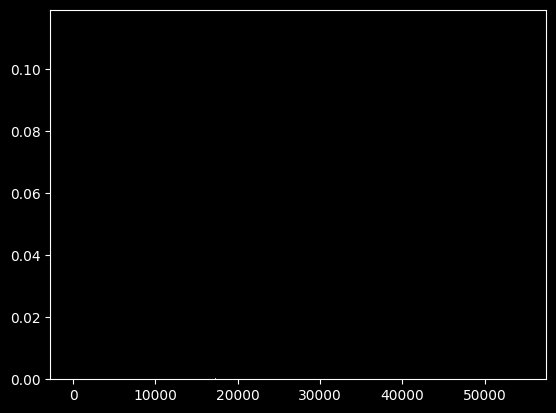

In [37]:
# get importance
importance = model.feature_importances_
# summarize feature importance
for i,v in enumerate(importance):
 print('Feature: %0d, Score: %.5f' % (i,v))
# plot feature importance
plt.bar([x for x in range(len(importance))], importance)
plt.show()

## Finding the optimal depth for the decision tree to validate the gridsearch parameter

In [38]:
# List of values to try for max_depth:
max_depth_range = list(range(1, 20))
# List to store the accuracy for each value of max_depth:
accuracy = []
for depth in max_depth_range:
    
    clf = DecisionTreeClassifier(max_depth = depth, 
                             random_state = 2)
    clf.fit(X_train, y_train)
    score = clf.score(X_test, y_test)
    accuracy.append(score)

max_accuracy = max(accuracy)
max_depth = max_depth_range[accuracy.index(max_accuracy)]
print("Max accuracy:", max_accuracy)
print("Corresponding max depth:", max_depth)

Max accuracy: 0.5144975969954486
Corresponding max depth: 12


In [39]:
# Import the f1 score and show how good the model is.
f1 = f1_score(y_test, model.predict(X_test),average='macro')
f1

0.23093509278499266

<function matplotlib.pyplot.show(close=None, block=None)>

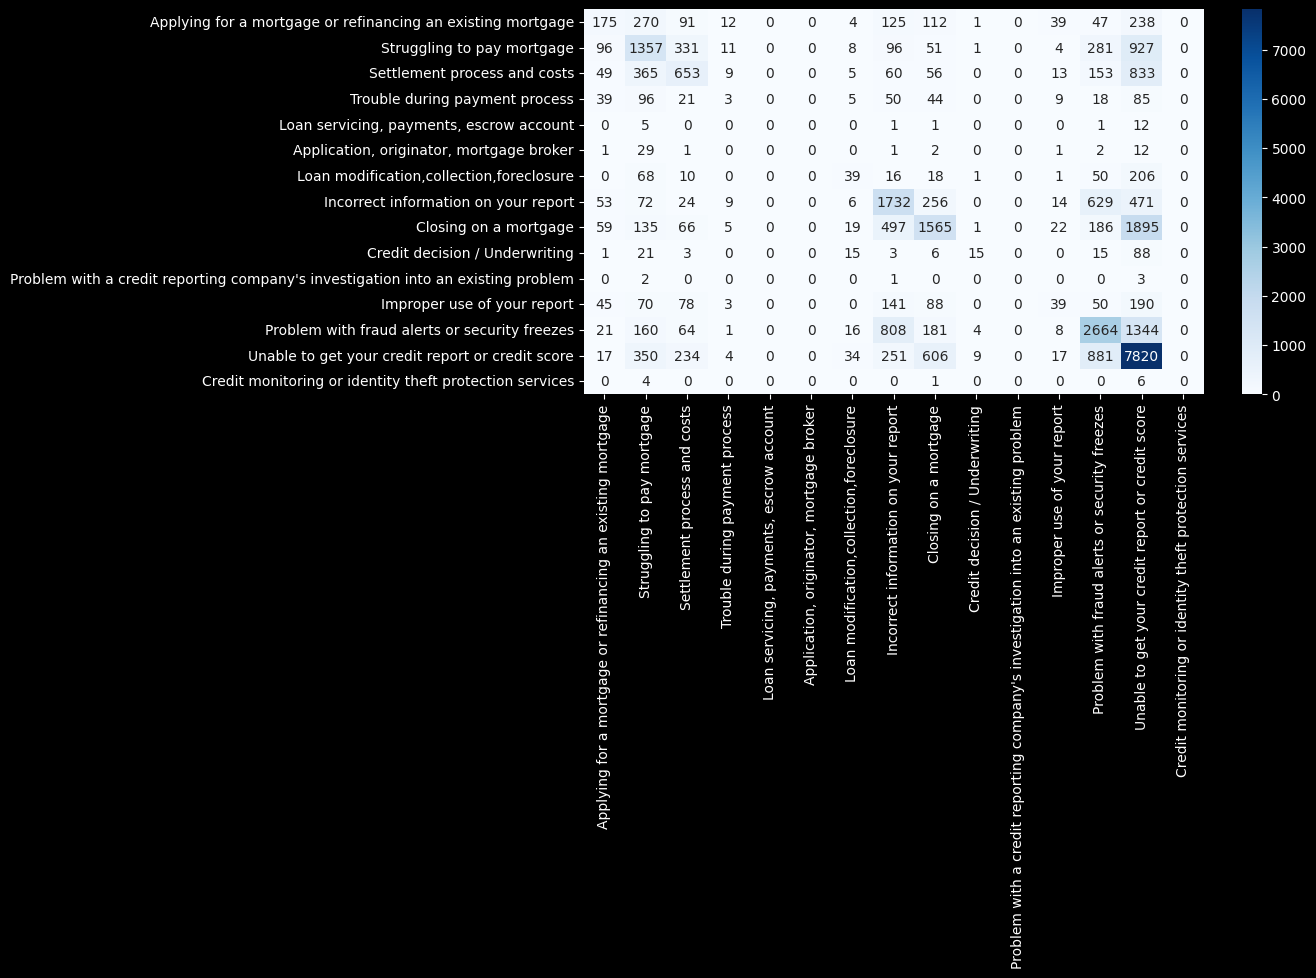

In [40]:
# Make predictions on the test set
y_pred = model.predict(X_test)

# Compute the confusion matrix
cm = confusion_matrix(y_test, y_pred,)

# Plot the confusion matrix using Seaborn heatmap
labels = data['Issue'].unique()

plt.figure(figsize=(10, 5))
sns.heatmap(cm, annot=True, cmap="Blues", fmt="d" ,xticklabels=labels, yticklabels=labels)

plt.show


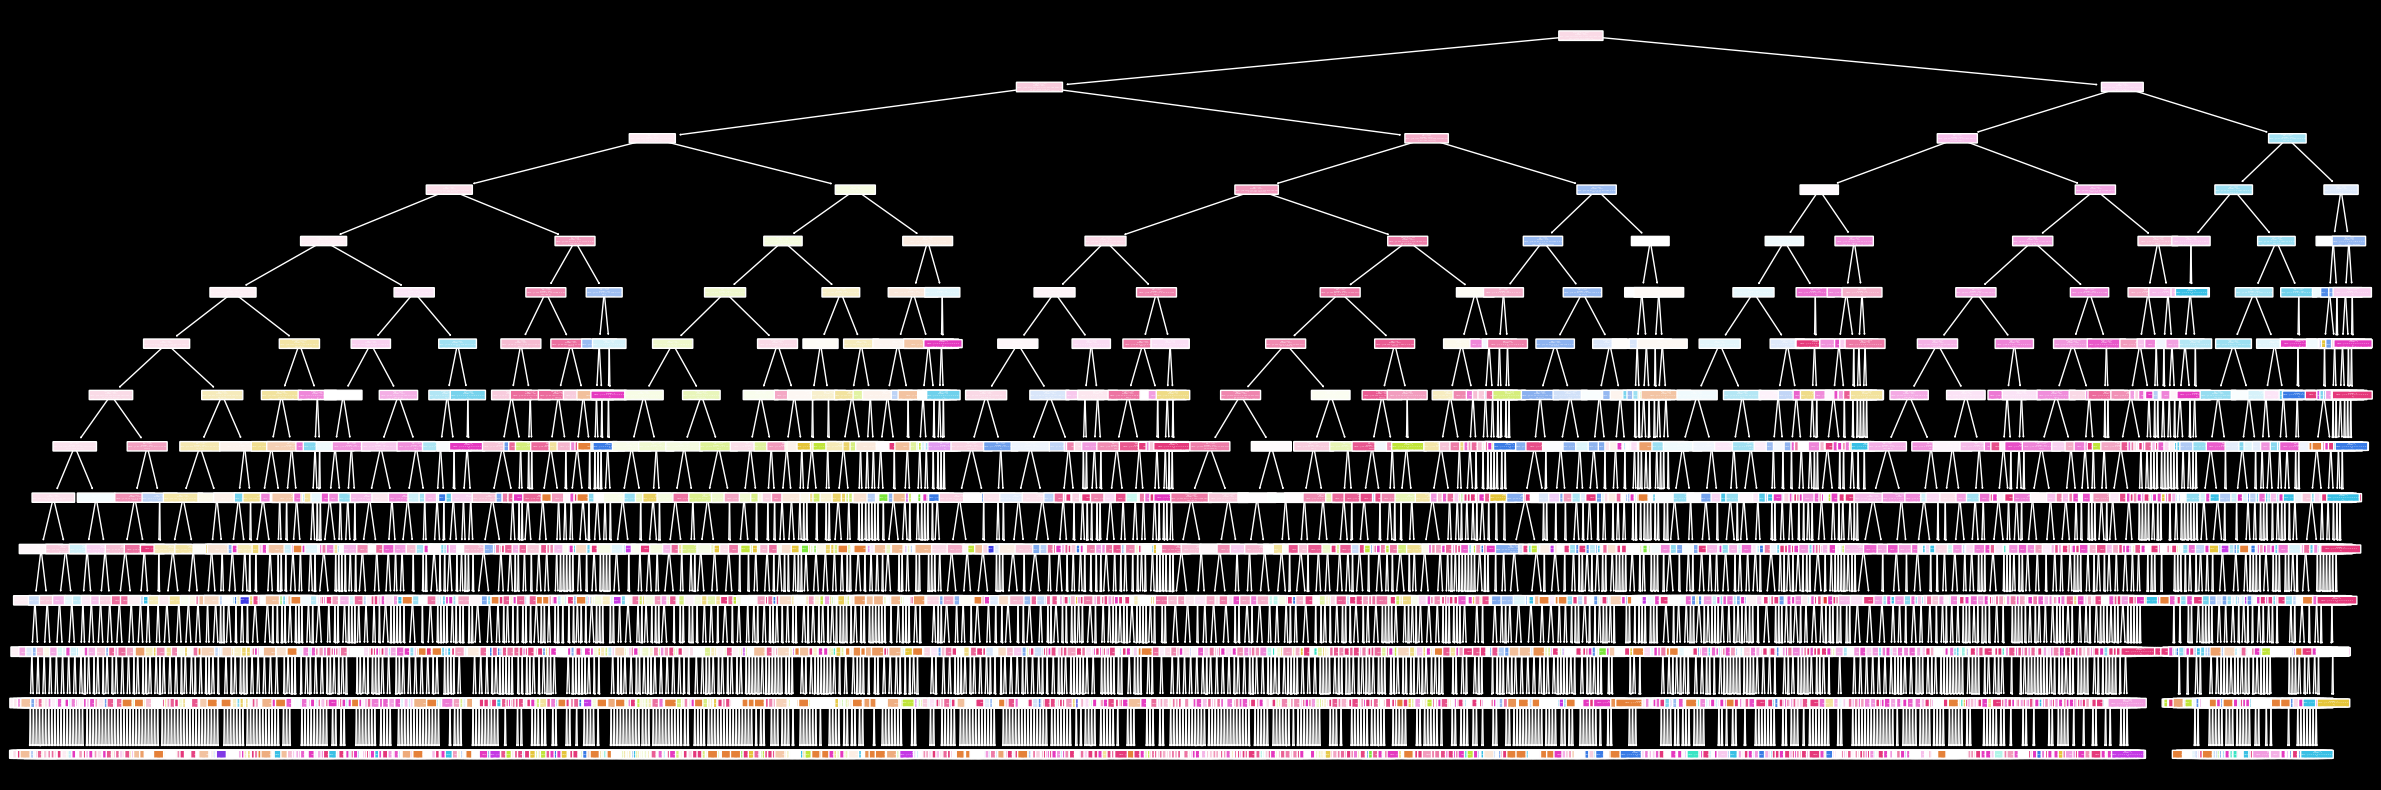

In [41]:
# Visualize the decisiontree
plt.figure(figsize=(30, 10))
tree = plot_tree(model, filled=True, max_depth=14, class_names=labels, feature_names=feature_names, rounded=True)
plt.show(tree)

